In [1]:
# our method
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(7)
import numpy as np
import torch
import model
import matplotlib.pyplot as plt

n = 1435
lamda = 1
m = 1000
d = 6
para_value = np.ndarray((200,2))
nonpara_value = np.ndarray((200))

device = 'cpu'

checkpoint = torch.load("./checkpoint/partial_linear_main_%d_%.3f_%d.pth"%(n,lamda,m))

over_net = model.Net(d,layer_mat=[d,m,m,m,m,1])
over_net_initial = model.Net(d,layer_mat=[d,m,m,m,m,1])
over_net = over_net.to(device)
over_net_initial = over_net_initial.to(device)
over_net_initial.load_state_dict(checkpoint['init_net'])
over_net.load_state_dict(checkpoint['over_net'])

path_train_data = "./data/partial_linear_train.npz"
data = np.load(path_train_data)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/tmp/ipykernel_245911/1413518742.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on

In [31]:
import copy

if not os.path.isdir('data'):
    os.mkdir('data')
if not os.path.isdir('output'):
    os.mkdir('output')
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')

path_train_data = "./data/partial_linear_train.npz"
path_validation_data = "./data/partial_linear_validation.npz"
path_test_data = "./data/partial_linear_test.npz"

# Data            
raw_data_1 = np.genfromtxt('Aotizhongxin.csv', delimiter=',', skip_header=1)
raw_data_2 = np.genfromtxt('Changping.csv', delimiter=',', skip_header=1)
raw_data = np.concatenate((raw_data_1,raw_data_2),axis=0)

# split
x_data = copy.deepcopy(raw_data[:,(6,10)])
t_data = copy.deepcopy(raw_data[:,(4,5,7,8,9,12)])
y_data = copy.deepcopy(raw_data[:,3:4])

# normalization
x_data_mean = np.mean(x_data,axis=0)
x_data_std = np.std(x_data,axis=0)
x_data = (x_data - x_data_mean)/x_data_std
y_data_mean = np.mean(y_data,axis=0)
y_data_std = np.std(y_data,axis=0)
y_data = (y_data - y_data_mean)/y_data_std
# y_data = np.log(y_data)
t_data_mean = np.mean(t_data,axis=0)
t_data_std = np.std(t_data,axis=0)
t_data = (t_data - t_data_mean)/t_data_std

In [53]:

def net(x):
    output = over_net(x) - over_net_initial(x)
    return(output)

In [7]:
var_x = ["SO2","NO2","O3","TEMP","PRES","WSPM"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


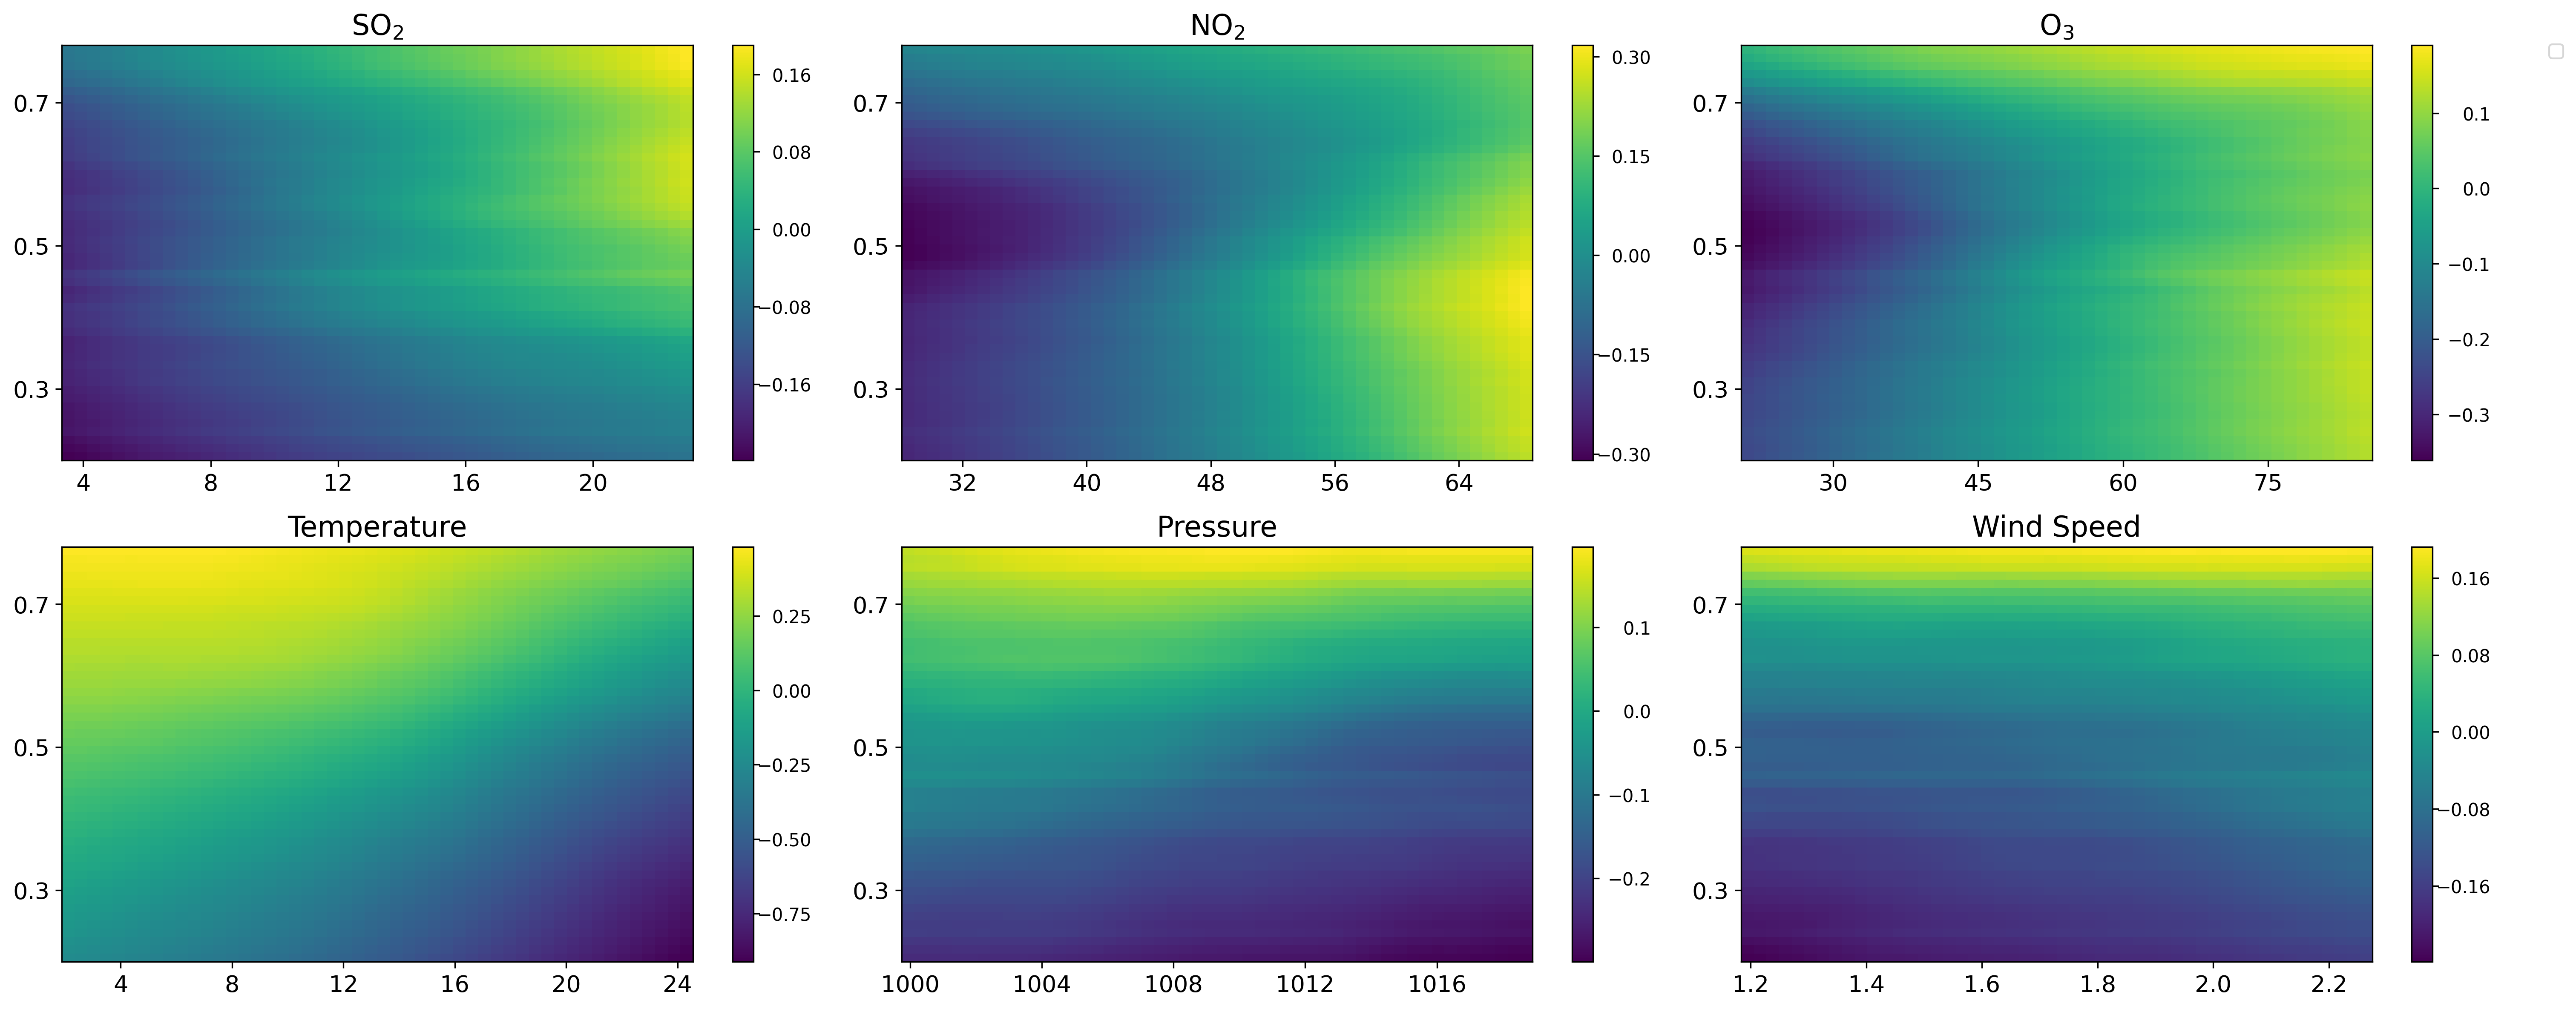

In [54]:
from matplotlib.ticker import MaxNLocator

def subplotv_heatmap(ax, i):
    N = 50  # 横坐标分辨率
    M = 50    # 分位数个数
    percentiles = np.linspace(20, 78, M)

    x_vals = np.linspace(
        np.percentile(data['t'], 20, axis=0)[i],
        np.percentile(data['t'], 78, axis=0)[i],
        N
    )
    x_plot_r = x_vals * t_data_std[i] + t_data_mean[i]

    # 初始化热力图数据
    heatmap = np.zeros((M, N))

    for j, p in enumerate(percentiles):
        zb = np.percentile(data['t'], p, axis=0)
        zb[i] = -1  # 当前变量由 x_vals 控制

        # 构建输入张量
        x_plot = np.tile(zb, N).reshape(-1, 1, 6)
        ind = np.where(np.array(zb) == -1)[0][0]  # 当前变量位置
        x_plot[:, :, ind] = x_vals.reshape(-1, 1)

        x_tensor = torch.from_numpy(x_plot).float().to(device)
        y = net(x_tensor).cpu().detach().numpy().reshape(-1)

        heatmap[j, :] = y  # 每行是一个分位数结果

    # 画热力图
    im = ax.imshow(
        heatmap,
        extent=[x_plot_r[0], x_plot_r[-1], percentiles[0], percentiles[-1]],
        aspect='auto',
        origin='lower',
        cmap='viridis'
        # cmap='Spectral_r'
    )
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.tick_params(axis='both', which='major', labelsize=13)
    
    ax.set_title(title_r[i], size=16)
    # ax.set_xlabel(f'{var_x[i]} (standardized)')
    # ax.set_ylabel('Other Variables Percentile')
    ax.set_yticks([30,50,70])
    ax.set_yticklabels(['0.3', '0.5', '0.7'])
    # plt.colorbar(im, ax=ax, label='Network Output')
    cbar = plt.colorbar(im, ax=ax)#, label='Model Output'
    # 设置 colorbar 的主刻度间距为 0.1
    cbar.locator = MaxNLocator(nbins=6)
    cbar.update_ticks()
    for label in cbar.ax.get_yticklabels():
        label.set_horizontalalignment('right')
        label.set_x(3.2)  # 将文本靠近颜色条的右边缘
    
    
title_r = ["SO$_2$","NO$_2$","O$_3$","Temperature","Pressure","Wind Speed"]
fig, ((ax1, ax2, ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, dpi=300,figsize=(20,8))
# fig.text(s='Output',rotation=90,x = -0.01, y = 0.45,fontsize = 22,) 
fig.legend(loc=2, bbox_to_anchor=(1,0.95), borderaxespad = 0.)
subplotv_heatmap(ax1,0)
subplotv_heatmap(ax2,1)
subplotv_heatmap(ax3,2)
subplotv_heatmap(ax4,3)
subplotv_heatmap(ax5,4)
subplotv_heatmap(ax6,5)

plt.tight_layout()  


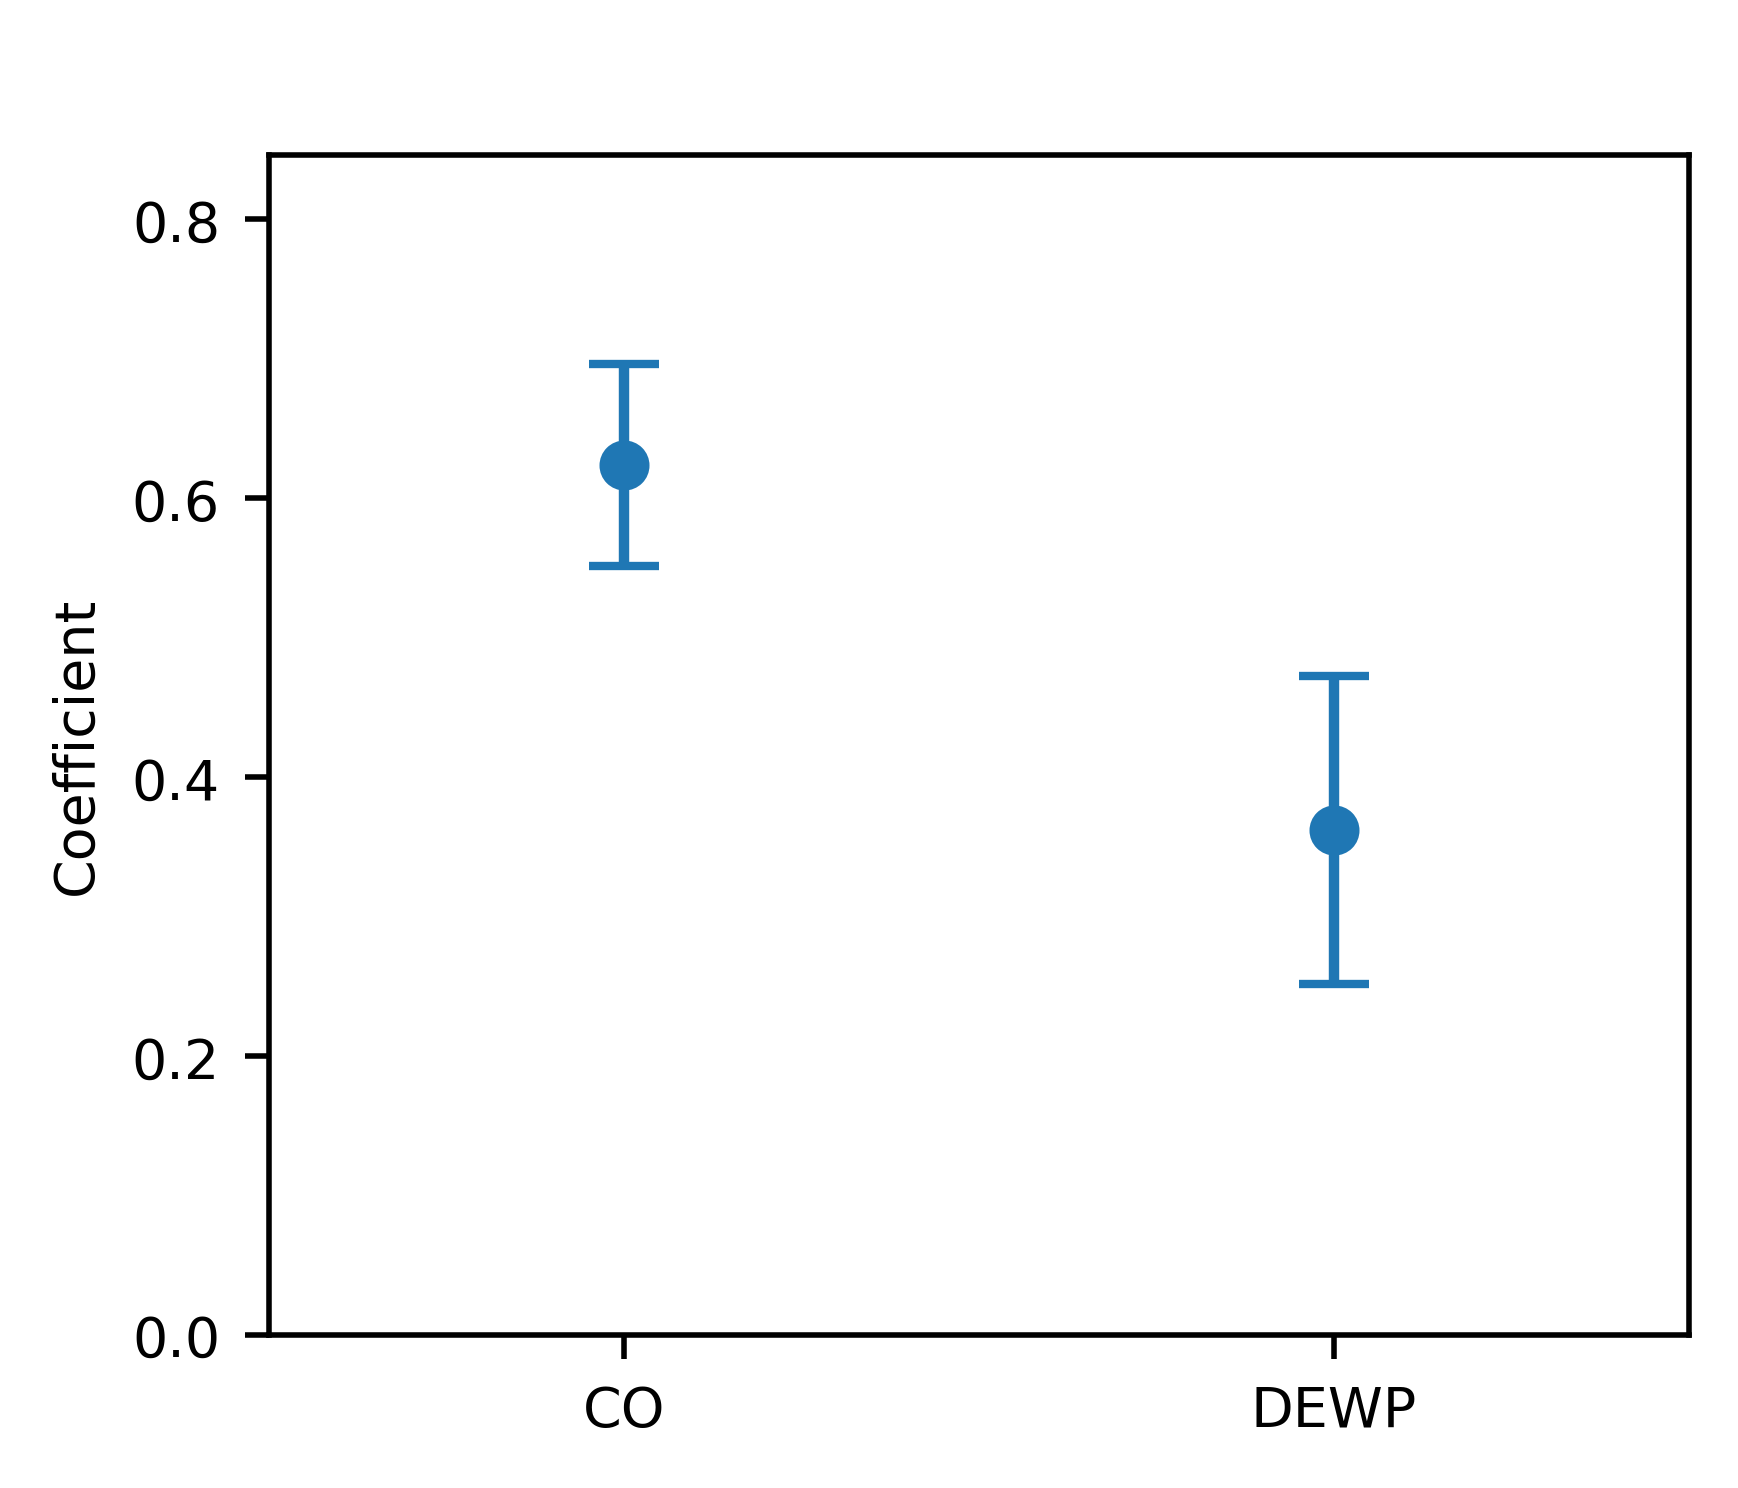

In [47]:
import matplotlib.pyplot as plt

# 数据
variables = ['CO', 'DEWP']
means = [0.6239, 0.3626]
cis = [[0.5515, 0.6964], [0.2523, 0.4730]]
errors = [(hi - lo) / 2 for lo, hi in cis]

x = range(len(variables))

# 画图
fig, ax = plt.subplots(figsize=(5.5, 5), dpi=500)

ax.errorbar(
    x, means, yerr=errors,
    fmt='o', color='#1f77b4', ecolor='#1f77b4',  # 主色调
    elinewidth=1.5, capsize=5, markersize=6, markeredgewidth=1.2
)

# 轴设置
ax.set_xticks(x)
ax.set_xticklabels(variables, fontsize=8)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8], fontsize=8)
ax.set_ylabel('Coefficient', fontsize=8)
ax.set_title(' ')

# 网格和边界
# ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(0, max([hi for _, hi in cis]) + 0.15)

# 去掉上边和右边框
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout(pad=8)  # 默认是 1.08
plt.show()